# Obermeyer Case Simulation

This notebook was created to simulate the Obermeyer parka purchasing case starting from the normal distributions Wally Obermeyer had constructed from previous years of data.

In [1]:
# To speed up computations, the kernel was ran on GPU via CuPy.
# You can change the import to numpy to run on a local machine
# without CUDA installed.
import cupy as np
# Packages to display results
from IPython.display import display, HTML
import pandas as pd
import matplotlib

## Our approach

Our plan is to **place the first order with different combinations of styles**, and see which ways optimizes costs.
We will try ordering
- half of the forecast for each style
- larger quantities for more volatile styles
- smaller quantities for more volatile styles

To simplify our analysis, we take the first three products from **Exhibit 10**.

In [2]:
products = {
    "gail":(1017, 388),
    "isis":(1042, 646),
    "entice":(1358, 496)
}

## Initializing

In [3]:
# Extract the gaussian parameters from the dictionary
product_distribution_moments = np.array(list(products.values()))
means = product_distribution_moments[:,0]
std_devs = product_distribution_moments[:,1]

As our approach simplifies the already simplified case of 20.000 units of capacity per season, we assume that the production capacity is equal to the sum of the forcasts of the Buying Committee for the three selected styles

In [4]:
production_capacity = np.sum(means)
print('Total seasonal production capacity: {}.\nFor this reason, the first order MOQ is {}'.format(production_capacity, production_capacity/2))

Total seasonal production capacity: 3417.
For this reason, the first order MOQ is 1708.5


We do not round to integer. With this type of analysis, the impact of this choice is negligible.

## Defining the simulation

The function below is the core of the simulation.

The first order is the main input, and it is parametrized as a vector of three numbers.

The second parameter is the number of simulations to run.

The simulation returns two values, the average cost over all simulations we will incur for overstocking certain styles and understocking other styles.

In [5]:
def run_simul(first_order, num_simulations):
    # Generate the final demand
    gaussian_realizations = np.random.normal(loc=means, scale=std_devs, size=(num_simulations,3))
    gaussian_realizations[gaussian_realizations<0] = 0

    # Compute delta between demand and november order
    delta_orders = gaussian_realizations - first_order

    # Overstocks are products for which we already overshot during the first order
    overstock = np.absolute(np.sum(delta_orders * (delta_orders < 0), axis=1))
    # Missed sales is the products we won't be able to produce due to capacity
    # constraints despite knowing the end of season values
    remaining_demand = np.sum(delta_orders * (delta_orders > 0), axis=1)
    remaining_capacity = production_capacity - first_order.sum()
    missed_sales = remaining_demand - remaining_capacity
    # In the cases where the remaining demand is fewer than the remaining capacity,
    # we will not use the full capacity. The missed sales calculation gives negative
    # results (more capacity than demand). In reality, the missed sales in those cases
    # are zero.
    missed_sales[missed_sales < 0] = 0

    # Costs on overstack are one per unit, missed sales are three per unit
    overstock_cost = overstock
    missed_sales_cost = missed_sales * 3
    
    return overstock_cost.mean(), missed_sales_cost.mean()

## Running the simulation

Having defined the code that will take in and process our orders, in this section we 'create' the orders and run them through the simulation function.

In [20]:
# Number of rounds the simulation will be ran for
# With the hardware that was available to us, we were able to
# run simulation batches of 150 million realizations.
# With such a large batch, we were able to obtain constant
# descriptive statistics across runs
num_simuls = int(1.5e8)

In [7]:
def print_order_details(order_name, order_quantities):
    print('The order "{}" contains:'.format(order_name))
    for style_name, style_quantity in zip(products.keys(), order_quantities):
        print('\t{} units of style {}.'.format(style_quantity, style_name))
    print('Total order quantity: {}\n'.format(order_quantities.sum()))

### Ordering half of the forecast for each style

In [8]:
# Creating the order
half_mean_first_order = means/2

# Checking if the order is as expected
print_order_details('Half-mean order', half_mean_first_order)

The order "Half-mean order" contains:
	508.5 units of style gail.
	521.0 units of style isis.
	679.0 units of style entice.
Total order quantity: 1708.5



In [9]:
# Running the simulation and storing the costs
overstock_cost, missed_sales_cost = run_simul(half_mean_first_order, num_simuls)

In [19]:
# Creating HTML content to display the results prominently
html_content = f"""
<div style="font-size:20px; color: black;">
    <p>Overstock cost: {int(overstock_cost)} u</p>
    <p>Missed sales cost: {int(missed_sales_cost)} u</p>
</div>
"""

# Displaying the HTML content
display(HTML(html_content))

In the case of ordering exactly half of the forecast, we would incur overstocking costs equal to 97u and missed sales costs equal to 1123u.

One unit **does not** correspond to a parka. It's rather a standalone costing unit that is used for relative comparisons across simulations.

### Ordering more of the volatile style

Now we run a series of simulations in which we gradually increase the number of units ordered in the volatile style, which is style number 2, "isis".
The intuition is that we expect to be able to be better prepared to capture the cases of high demand if we start off with a considerable order in the volatile style.

In [11]:
# Number of units added to the volatile style for each simulation.
# As we only order MOQ, the other two styles will be reduced by
# half of the increase, each
quantity_variations = [10,20,50,100,200,400]

In [12]:
# Array to store results for later visualizations
overorder_results = []

# Run simulation with increasing units
for extra_units in quantity_variations:
    print('Running simulation with {} extra units of the volatile style.'.format(extra_units))
    # Create the order
    overorder_volatile_stles = half_mean_first_order.copy()
    overorder_volatile_stles[[0,2]] -= extra_units/2
    overorder_volatile_stles[1] += extra_units
    
    # print_order_details('Volatile {} extra'.format(extra_units), overorder_volatile_stles)
    overorder_results.append(run_simul(overorder_volatile_stles, num_simuls))

Running simulation with 10 extra units of the volatile style.
Running simulation with 20 extra units of the volatile style.
Running simulation with 50 extra units of the volatile style.
Running simulation with 100 extra units of the volatile style.
Running simulation with 200 extra units of the volatile style.
Running simulation with 400 extra units of the volatile style.


### Visualizing results

In [13]:
col_names = ['overstock_costs', 'missed_sales_costs']

overorder_viz_dataframe = pd.DataFrame(overorder_results, columns=col_names).astype('int')
overorder_viz_dataframe['extra_units'] = quantity_variations

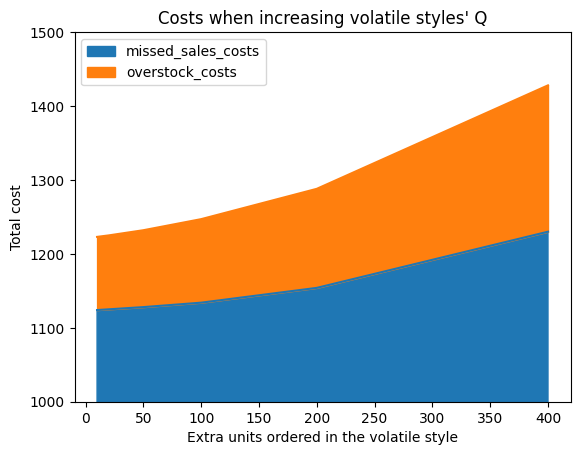

In [26]:
overorder_viz_dataframe.plot.area(
    x='extra_units', 
    y=['missed_sales_costs', 'overstock_costs'], 
    ylim=[1000, 1500], 
    ylabel='Total cost', 
    xlabel='Extra units ordered in the volatile style',
    title='Costs when increasing volatile styles\' Q'
).legend(loc='upper left')
print()

The result goes against our intuition: as we increase the size of the volatile order, both our costs increase.

### Ordering less of the volatile style

We do the opposite exercise as above: we gradually decrease the quantity ordered in the volatile style.

In [15]:
# Array to store results for later visualizations
underorder_results = []

# Run simulation with decreasing ordered units
for fewer_units in quantity_variations:
    print('Running simulation with {} fewer units of the volatile style.'.format(fewer_units))
    # Create order
    underorder_volatile_stles = half_mean_first_order.copy()
    underorder_volatile_stles[[0,2]] += fewer_units/2
    underorder_volatile_stles[1] -= fewer_units
    
    # print_order_details('Volatile {} fewer'.format(fewer_units), underorder_volatile_stles)
    underorder_results.append(run_simul(underorder_volatile_stles, num_simuls))

Running simulation with 10 fewer units of the volatile style.
Running simulation with 20 fewer units of the volatile style.
Running simulation with 50 fewer units of the volatile style.
Running simulation with 100 fewer units of the volatile style.
Running simulation with 200 fewer units of the volatile style.
Running simulation with 400 fewer units of the volatile style.


### Visualizing results

In [16]:
col_names = ['overstock_costs', 'missed_sales_costs']

underorder_viz_dataframe = pd.DataFrame(underorder_results, columns=col_names).astype('int')
underorder_viz_dataframe['fewer_units'] = quantity_variations

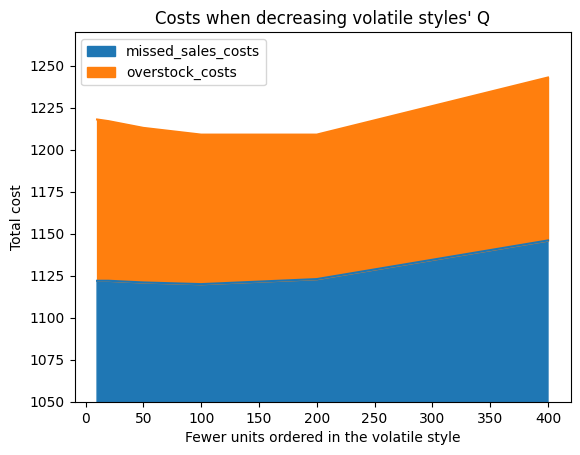

In [28]:
underorder_viz_dataframe.plot.area(
    x='fewer_units', 
    y=['missed_sales_costs','overstock_costs'], 
    ylim=[1050,1270], 
    ylabel='Total cost', 
    xlabel='Fewer units ordered in the volatile style',
    title='Costs when decreasing volatile styles\' Q'
).legend(loc='upper left')
print()

It seems that, up to a certain extent, reducing the ordered quantity of the volatile style and increasing the order quantities of the less volatile styles, reduces both our overstocks and the number of sales we miss of a few units.

## Limitations

- This model, like all others is wrong. Before addressing how it was useful in the conclusions, we will hypothesize how it is wrong. If each year all styles are new, it is impossible for Wally to fit a normal distribution for each style, as there is a single datapoint. The distribution was probably fit including all styles, but this does not mean that it applies to each style. The opposite is true: in **Exhibit 5** we clearly see there is a "jackpot" style that is the lead seller of the season, while all the others sell below expectations. Fitting a gaussian on the observations of real demand gives a mean that is likely similar to the forecast mean, because the market size does not change much year over year; in terms of standard deviation, we hypothesize that the ratio between the Buyer Committee's one and the real one is not significant. The obtained gaussian is very flat, going towards a uniform distribution, or a totally random model.
- Our analysis is incomplete. Disregarding the fact that we did not scale up the simulation to the entire order set, we did not explore all effects in this smaller sample either. For example, we did not inspect what the behavior of an unequal re-distribution of the units removed from the volatile style entails.
- Our analysis is approximate. The sample we took is simply the first three elements of **Exhibit 10**, so it's unlikely to be representative. The size of increase/decrease of the orders is arbitrary. We did not take into account the ratio of standard deviation over mean of the two other styles when re-allocating ordered quantities between styles.
- We only analyse the case of ordering the MOQ. This is because our intuition tells us it is better to wait to commit more units for production only after more accurate data is available.
- In the case where the final seasonal demand is below capacity, our simulation leaves capacity unused. This, in reality, might mean that we do not fulfill our manufacturing agreement.

## Conclusion

The simulation of a near-random model created with unclear assumptions is not very useful.

One thing that the model taught us is that statistical intuitions need to be double checked. We expected to be able to reduce missed sales by increasing the size of the orders of volatile styles, but the opposite was true.

One very notable outcome of the exercise is the fact that, with the given model, most of our costs incur in terms of missed sales. This made us question how this was possible given the distribution of points in **Exhibit 5a**, where most of the final sales were well below predictions. From this reflection, we realized that all the missed sales must have been coming from the "jackpot" style, coming to the conclusion that the *model* was created across styles, not for each style. In fact, as we were reading the text, we were puzzled of what the "standard deviation" of a style could mean, as each style only had one observation.

As we have been proven to be wrong by this exercise once, it could be that our current intuition is biased and the underlying reasons for the results we obtained are still obscure to us, but at least we have a good narrative to sell to management :)